# 第六週: 英文文集的情緒分析2

**Author:** 劉岱宜<br>
**Date created:** 2021/09/21<br>
**Last modified:** 2020/09/21<br>
+ 資料來源:
    + twitter api 爬取貼文
    + 關鍵字:「COVID19vaccine」(3000筆)
    + 時間: "2021-09-15" 到 "2021-09-20"
+ 分析方式
    + POS、NER、sentiment coreNLP
+ 分析流程
    + 1. coreNLP 介紹
    + 2. 文章抓取 & coreNLP 標註
        + 1. 抓取twitter貼文
        + 2. coreNLP 斷詞擷取POS、NER、sentiment
    + 3. 開始分析
        + 1. NER、POS相關分析
        + 2. 分析情緒，劃出日期情緒趨勢與相關字詞

In [61]:
import stanza ## pip install stanza
from stanza.server import CoreNLPClient
from ipywidgets import IntProgress ## pip install ipywidgets

import os
import time
import pandas as pd

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS ## pip install wordcloud

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt

## Part 1：coreNLP介紹

### 下載coreNLP 套件
+ 可以用stanza管理NLP的相關模型

In [2]:
stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

2021-09-22 12:00:30 WARNING: Directory ./stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [3]:

os.environ['CORENLP_HOME'] = "./stanza_corenlp"

### 開啟CoreNLP client 端

+ 每次使用CoreNLP套件就需要開啟Client
+ 可以設定相關的port和處理的memory大小
+ 記得每次開起來之後要把client關掉，可以用with語法確保每次執行完自己關掉
    
以下用簡單的範例說明

In [4]:
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9000
client = CoreNLPClient(
             # client要處理的項目
            annotators=['tokenize','ssplit','sentiment'],     
            memory='4G', 
            endpoint='http://localhost:9008',
            be_quiet=True
        )

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(5)

2021-09-22 12:00:32 INFO: Writing properties to tmp file: corenlp_server-cceef8ab5daf4243.props
2021-09-22 12:00:32 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9008 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-cceef8ab5daf4243.props -annotators tokenize,ssplit,sentiment -preload -outputFormat serialized


In [5]:
# 將要分析的字串傳入client，得到coreNLP的document object
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
document = client.annotate(text)
print(type(document))

<class 'CoreNLP_pb2.Document'>


In [6]:
# text 會被分成個句子，用for迴圈把每個字取出來，看看對應的 lemma, pos and ner tags 標籤
print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")  
    
for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

Word        	Lemma       	POS   	NER
A           	            	DT    	
blog        	            	NN    	
post        	            	NN    	
using       	            	VBG   	
Stanford    	            	NNP   	
CoreNLP     	            	NN    	
Server      	            	NN    	
.           	            	.     	

Visit       	            	VB    	
www.khalidalnajjar.com	            	ADD   	
for         	            	IN    	
more        	            	JJR   	
details     	            	NNS   	
.           	            	.     	



In [7]:
for i, sent in enumerate(document.sentence):
    
    # get the constituency parse of the sentence
    constituency_parse = sent.parseTree # child 
    print(constituency_parse)

    # get the dependency parse of the first sentence
    dependency_parse = sent.basicDependencies # edge
    print(dependency_parse)    

child {
  child {
    child {
      child {
        value: "A"
      }
      value: "DT"
      score: -4.670736789703369
    }
    child {
      child {
        value: "blog"
      }
      value: "NN"
      score: -9.66670036315918
    }
    child {
      child {
        value: "post"
      }
      value: "NN"
      score: -7.835064888000488
    }
    value: "NP"
    score: -26.095684051513672
  }
  child {
    child {
      child {
        value: "using"
      }
      value: "VBG"
      score: -3.688901901245117
    }
    child {
      child {
        child {
          value: "Stanford"
        }
        value: "NNP"
        score: -9.325450897216797
      }
      child {
        child {
          value: "CoreNLP"
        }
        value: "NN"
        score: -16.279035568237305
      }
      child {
        child {
          value: "Server"
        }
        value: "NN"
        score: -12.386455535888672
      }
      value: "NP"
      score: -47.03589630126953
    }
    value: "VP"
 

In [8]:
# 最後再把背景的client關掉
client.stop()
time.sleep(5)
!ps -o pid,cmd | grep java

28369 /bin/bash -c ps -o pid,cmd | grep java
28371 grep java


#### Dependency 視覺化
+ 官網範例: https://corenlp.run/

需要利用terminal下指令把coreNLP開起來
1. cd 透過stanza套件下載corenlp模型的資料夾 `./stanza_corenlp`
2. 用java指令把CoreNL服務打開<br/>`java -mx1g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9010 -timeout 15000`

In [9]:

parser = CoreNLPParser('http://localhost:9010')
text = 'the quick brown fox jumps over the lazy dog'
parser.raw_parse(text)

fox_parsed = next(parser.raw_parse(text))
fox_parsed.pretty_print()

                     ROOT                      
                      |                         
                      S                        
       _______________|_________                
      |                         VP             
      |                _________|___            
      |               |             PP         
      |               |     ________|___        
      NP              |    |            NP     
  ____|__________     |    |     _______|____   
 DT   JJ    JJ   NN  VBZ   IN   DT      JJ   NN
 |    |     |    |    |    |    |       |    |  
the quick brown fox jumps over the     lazy dog



## Part 2：將分析過程串起來

### Step 1：用twitter抓資料
+ 首先申請twitter 相關的 token secret
+ https://developer.twitter.com/en/docs/tutorials/step-by-step-guide-to-making-your-first-request-to-the-twitter-api-v2
+ 申請完之後token會在 Developer Portal > project & Apps > Keys and tokens

In [10]:
import tweepy as tw # pip install tweepy
# API Key and Secret
CONSUMER_KEY = 'eNMQchTiHN7WjnQksfvHAJgA9'
CONSUMER_SECRET = 'MS5xRYuRUERepYaSeABsNjREf9Fvthr7ihsrtswYqBm51GTvPB'
# Access Token and Secret
OAUTH_TOKEN = '1193849843279511552-dXvAjOpZjXFI5BTDLZBW5Ljq551OG1'
OAUTH_TOKEN_SECRET = 'wWGtd0HmThSgHh5Gdi1VDrVRATm1sHJpMi3gcFBC1qxGT'

In [11]:
# 開通api權限
auth = tw.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

In [12]:
# 將抓到的twitter文章轉為datafranme

def twitter_table(keyword, from_date,end_date, lang_type,limit):
    
    # 定義 search api 參數
    all_tweets = tw.Cursor(
                        api.search,
                        q=keyword,
                        lang=lang_type,
                        since=from_date,
                        until=end_date
                    ).items(limit)    
    
    # 抓取tweet的 attribute
    tweets_list= [[tweet.created_at, tweet.id, tweet.user.screen_name,
               tweet.user.name, tweet.text, tweet.favorite_count, tweet.retweet_count,tweet.source
              ] for tweet in all_tweets]
    
    # 定義欄位名稱
    tweet_table = pd.DataFrame(data=tweets_list, 
                        columns=['created_at','status_id', 'user_id',
                                 'user_name', 'text','favourites', 'retweet','source'])
        
    tweet_table = tweet_table[['created_at','status_id', 'user_id',
                               'user_name', 'text','favourites', 'retweet','source']]
    
    return tweet_table

+ 設定爬文的條件
    + 設定時間為 "2021-09-15" 到 "2021-09-20"
    + 文章須包含 「COVID19vaccine」關鍵字，爬文時api會忽略大小寫
    + `-filter:retweet` 不抓轉推、`-is:reply`不抓回文、`-is:nullcast`不抓廣告
    + 更多query 規則可以參考推特的文件
    + https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

In [13]:
keyword = "COVID19vaccine  -filter:retweet -is:reply -is:nullcast" #case-insensitive 
from_date = "2021-09-15"  #format "yyyy-mm-dd"
end_date = "2021-09-20" 
lang_type = "en" 
limit = 3000

In [14]:
# 透過twitter api抓取堆文，會需要等一會
# tweets_df = twitter_table(keyword, from_date,end_date, lang_type,limit)
# tweets_df

In [15]:
# # 將推特文章存成csv
# tweets_df.to_csv(r'source/eng/tweets_covid19vaccine.csv', index = False)

### Part 2：將抓取結果用coreNLP 分析

In [17]:
def get_nlp_result(tweets_df):    
    
    print("Starting a server with the Python \"with\" statement...")
    
    start = time.time()

    with CoreNLPClient(
        annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment'],
        memory = '4G', endpoint = 'http://localhost:9006' , be_quiet=True, 
    ) as client:
        
        token_list = []        
        senti_list = []        
        
        # 注意！！這裡只是示範所以只跑了5筆
        for index, row in tweets_df.head(5).iterrows(): # document level    
            # send text into client
            document = client.annotate(row['text'])                
            print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")               
             # sentence level
            for i, sent in enumerate(document.sentence):
                s = ""
                # token level
                for t in sent.token: 
                    s = s + " " + t.word # for sentence                
                    print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))                
                    temp_token = [row['status_id'],t.word, t.lemma, t.pos, t.ner]           
                    token_list.append(temp_token) 

                print("[Sentence {}:{}_____________]".format(i+1,s))  

                temp_senti = [row['status_id'],s,sent.sentiment]           
                senti_list.append(temp_senti)   

        token_table = pd.DataFrame(data=token_list, 
                            columns=['status_id','word','lemma','pos','ner'])        

        senti_table = pd.DataFrame(data=senti_list, 
                            columns=['status_id','word','sentiment'])        

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        return senti_table , token_table

In [18]:
## 讀取推特文章
tweets_df = pd.read_csv('./source/eng/tweets_covid19vaccine.csv')

# 找出NER、POS和sentiment分析結果
# 注意！！這裡只是示範所以只跑了5筆
sentiment , tokens = get_nlp_result(tweets_df)
# total time costing: 491.99625301361084

2021-09-22 12:05:08 INFO: Writing properties to tmp file: corenlp_server-978dbd6622aa40ac.props
2021-09-22 12:05:08 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9006 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-978dbd6622aa40ac.props -annotators tokenize,ssplit,pos,lemma,ner,sentiment -preload -outputFormat serialized


Starting a server with the Python "with" statement...
Word        	Lemma       	POS   	NER
RT          	rt          	NN    	O
@anitakissee	@anitakissee	NN    	HANDLE
:           	:           	:     	O
This        	this        	DT    	O
is          	be          	VBZ   	O
my          	my          	PRP$  	O
favorite    	favorite    	JJ    	O
#Covid19vaccine	#covid19vaccine	NN    	O
video       	video       	NN    	O
on          	on          	IN    	O
TikTok      	TikTok      	NNP   	O
right       	right       	RB    	DATE
now         	now         	RB    	DATE
.           	.           	.     	O
[Sentence 1: RT @anitakissee : This is my favorite #Covid19vaccine video on TikTok right now ._____________]
https://t.co/g4VvHPIX1f	https://t.co/g4vvhpix1f	ADD   	URL
https://t.co/AdzdVE2sBe	https://t.co/adzdve2sbe	ADD   	URL
[Sentence 2: https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe_____________]
Word        	Lemma       	POS   	NER
RT          	rt          	NN    	O
@anitakissee	@anitakissee	NN

In [43]:
# 儲存結果
# sentiment.to_csv(r'source/eng/sentiment_covid19vaccine.csv', index = False)
# tokens.to_csv(r'source/eng/tokens_covid19vaccine.csv', index = False)

+ coreNLP_tokens_parser欄位:
    + status_id : 對應原本df裡的status_id，為一則tweets的唯一id
    + word: 原始斷詞
    + lemma : 對斷詞做詞形還原
    + pos : part-of-speech,詞性
    + ner: 命名實體

## Part 3：實體辨識結果 & 情緒分析

In [19]:
# 讀取已經執行完畢的結果
tokens = pd.read_csv('source/eng/tokens_covid19vaccine.csv')
tokens.head(5)

,status_id,word,lemma,pos,ner
0,1439740696974409731,RT,rt,NN,O
1,1439740696974409731,@anitakissee,@anitakissee,NN,HANDLE
2,1439740696974409731,:,:,:,O
3,1439740696974409731,This,this,DT,O
4,1439740696974409731,is,be,VBZ,O


### NER 種類分析
+ 看看除了其他，大部分的NER都是哪一類

In [20]:
# 查看辨識出哪幾種NER
tokens['ner'].unique()

array(['O', 'HANDLE', 'DATE', 'URL', 'ORGANIZATION', 'NUMBER', 'MISC',
       'DURATION', 'TITLE', 'PERCENT', 'LOCATION', 'COUNTRY', 'PERSON',
       'CITY', 'ORDINAL', 'STATE_OR_PROVINCE', 'TIME', 'CAUSE_OF_DEATH',
       'NATIONALITY', 'MONEY', 'CRIMINAL_CHARGE', 'RELIGION', 'SET',
       'IDEOLOGY', 'EMAIL'], dtype=object)

In [21]:
# 'O' 代表 other，看看除了other，有幾個字有被標出 entity
len(tokens.loc[tokens['ner'] != 'O']['word'].unique()) # 2995個字有被標出entity

2995

In [22]:
tokens_filter = tokens.loc[tokens['ner'] != 'O']

ner_count = tokens_filter.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
7,HANDLE,2572
4,DATE,1795
15,ORGANIZATION,1611
13,NUMBER,1331
23,URL,1238
14,ORDINAL,570
9,LOCATION,513
21,TIME,483
17,PERSON,429
10,MISC,395


Text(0.5, 0, 'Frequency')

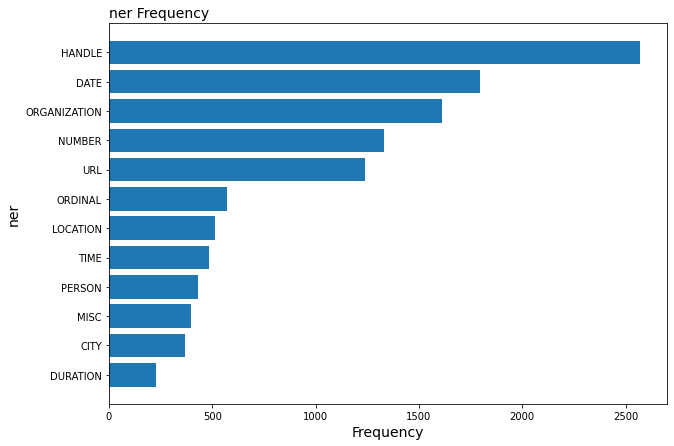

In [23]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)

### 探索分析 - NER

為了正確計算詞頻，將word轉小寫存新欄位

In [24]:
tokens['word_lower'] = tokens['word'].str.lower()
tokens['lemma_lower'] = tokens['word'].str.lower()
tokens.head(5)

,status_id,word,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT,rt,NN,O,rt,rt
1,1439740696974409731,@anitakissee,@anitakissee,NN,HANDLE,@anitakissee,@anitakissee
2,1439740696974409731,:,:,:,O,:,:
3,1439740696974409731,This,this,DT,O,this,this
4,1439740696974409731,is,be,VBZ,O,is,is


### 涉及到的國家(COUNTRY)
+ 透過coreNLP中的NER解析出在Twitter上面談論covid19，所涉及到的國家(COUNTRY)

In [25]:
# 篩選ner為country的資料
country = tokens.loc[tokens['ner'] == 'COUNTRY']

# 計算每個國家提到的次數，選出前13個
country_count = country.groupby('word_lower')['word_lower'].agg(['count'])
country_count = country_count.sort_values(['count'],ascending=False)['count'].nlargest(13).reset_index()
country_count.head(5)

,word_lower,count
0,india,55
1,australia,17
2,china,14
3,u.s.,13
4,israel,9


In [26]:
# 另外一種寫法
country_count = country[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(13)
country_count

,word_lower,count
12,india,55
3,australia,17
6,china,14
27,u.s.,13
14,israel,9
23,states,8
30,united,8
17,namibia,8
11,germany,6
19,pakistan,6


Text(0.5, 0, 'Word Frequency')

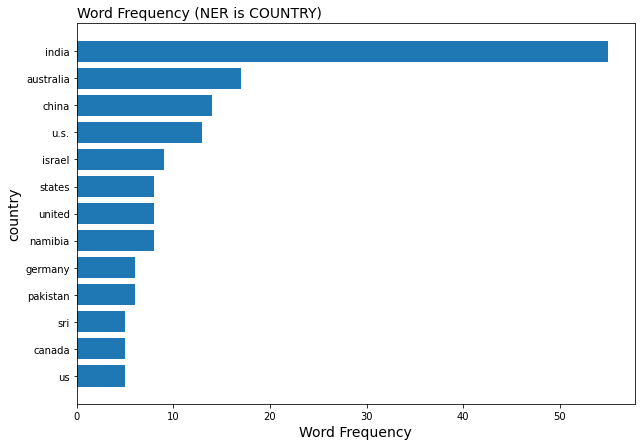

In [27]:

word = country_count['word_lower']
count = country_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is COUNTRY)',loc ='left', size = 14)
ax.set_ylabel('country', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

+ 可以抓取關鍵字貼文，來看看相關的貼文大致在說甚麼，
+ 最常出現的國家依序如下，以下挑出幾個比較特別的事件：
    + 印度: WHO 可能會批准印度的國產疫苗 Covaxin
    + 澳洲: 成為第一個要求進入公共產和需要出示疫苗接種證明的國家
    + 中國: 疫苗接種率高達 71% ，或是其他國家從中國購買疫苗的相關新聞
    + 美國: 各種官方呼籲接種疫苗、配到口罩的相關宣傳    

### 涉及到的組織(ORGANIZATION)
+ 我們可以透過coreNLP中的NER解析出在Twitter上面談論新冠肺炎時，所涉及到的組織(ORGANIZATION)

In [28]:
org = tokens.loc[tokens['ner'] == 'ORGANIZATION']
org_count = org[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(15)
org_count.head(5)

,word_lower,count
63,centre,72
1,&,51
201,pfizer,51
226,scarborough,47
17,ajax,37


Text(0.5, 0, 'Word Frequency')

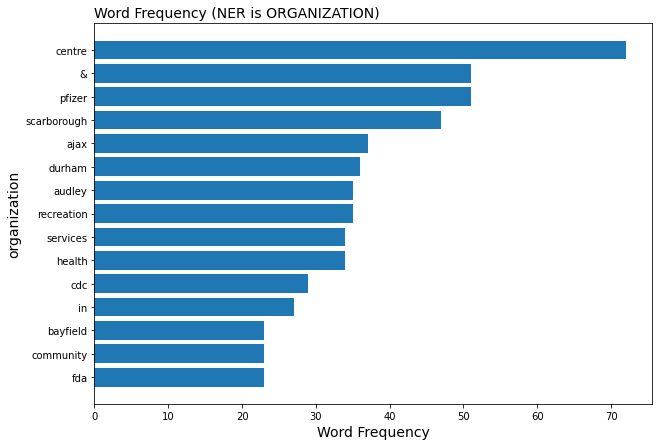

In [29]:
word = org_count['word_lower']
count = org_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

In [30]:
# 看一下含特定關鍵字的貼文內容
keyword_list = ['u.s.']
tweets_df[tweets_df['text'].str.contains('|'.join(keyword_list),regex=True)]

,created_at,status_id,user_id,user_name,text,favourites,retweet,source
33,2021-09-19 22:24:19,1439717013941886977,PamO88426052,PamO,#COVID19Vaccine \nWhy the hell are people pack...,0,0,Twitter for Android
59,2021-09-19 20:48:29,1439692898866384896,CPLCdotORG,CPLC,RT @pchd: In addition to the static COVID vacc...,0,4,Twitter for iPhone
91,2021-09-19 19:11:25,1439668468958203905,DEO_MonDistrict,DC & DEO Mon,RT @NagalandNhm: Time for Faith and Fact to ha...,0,4,Twitter for Android
130,2021-09-19 17:11:45,1439638353108865025,OurGadgets,Our Gadgets,RT @CaringFriendsH2: Get the Covid-19 vaccine ...,0,1,Twitter Web App
155,2021-09-19 16:00:36,1439620448833073152,fellowcreature,Fellow Creatures Ⓥ,Do anti-vaxxers live their lives taking no ris...,0,0,Twitter for Android
...,...,...,...,...,...,...,...,...
2950,2021-09-15 18:10:59,1438203710388281351,RadarsHockey,Clinton Radars 😷,RT @CentralHuron: WALK-IN #COVID19Vaccine (Pfi...,0,3,Twitter for iPad
2959,2021-09-15 17:55:37,1438199840337498112,RobinFuxa,Dr. Robin Fuxa,Keeping it going Oklahoma. If you haven't gott...,4,0,Twitter Web App
2973,2021-09-15 17:39:48,1438195860412813321,RachelSilby,Rachel Silberstein,"Not very useful to upstate NYers, but the stat...",0,0,Twitter Web App
2981,2021-09-15 17:20:20,1438190961981489152,newsgovhk,Hong Kong SAR Government News,The two scientific committees under the #Centr...,1,0,newsgovhk


+ pfizer: 輝瑞製藥公司
+ fda: 美國食品藥物管理局(可能為疫苗相關討論)
+ cdc: Centers for Disease Control and Prevention, 美國疾病管制與預防中心

### 涉及到的人物(PERSON)
+ 我們可以透過coreNLP中的NER解析出在Twitter上面談論新冠肺炎，所涉及到的人物(PERSON)

In [31]:
peo = tokens.loc[tokens['ner'] == 'PERSON']
peo_count = peo[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(10)
peo_count.head(5)

,word_lower,count
89,minaj,20
98,nicki,20
80,maria,18
5,anna,18
70,kildonan,18


Text(0.5, 0, 'Word Frequency')

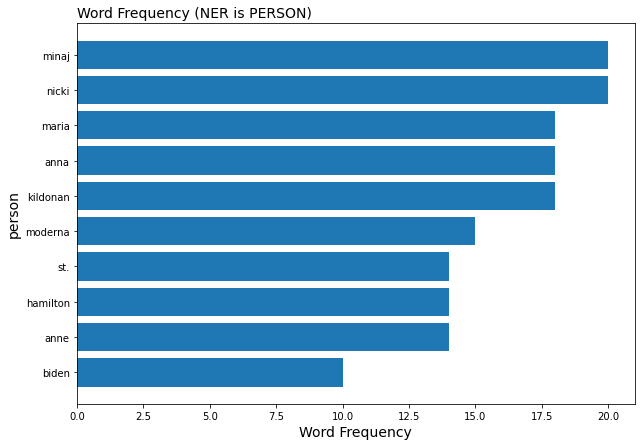

In [32]:
word = peo_count['word_lower']
count = peo_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('person', size = 14)
ax.set_xlabel('Word Frequency', size = 14)

+ Nicki Minaj: 美饒舌歌手，對疫苗安全性存疑，引來其他專家批評
+ biden: Joe Biden, 美國總統，呼籲大家接種疫苗

## 探索分析 - Sentiment

In [33]:
# 讀取已經執行完畢的結果
sentiment = pd.read_csv("source/eng/sentiment_covid19vaccine.csv")
sentiment.head(5)

,status_id,word,sentiment
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive
3,1439739935959912448,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral
4,1439739587694268416,RT @StanfordMed : Allergic reactions to the n...,Positive


In [34]:
# 看有哪些情緒
sentiment['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Very positive'], dtype=object)

In [35]:
# 看一下各情緒的分布
sentiment.groupby('sentiment')['sentiment'].agg(['count'])

,count
sentiment,
Negative,565
Neutral,3348
Positive,599
Very positive,1


In [36]:
# 把時間加到sentiment裡面
tweets_df = pd.read_csv("source/eng/tweets_covid19vaccine.csv") #匯資料
sentiment_date = pd.merge(sentiment, tweets_df[['status_id','created_at','source']], on="status_id", how='left')
sentiment_date.head(5)

,status_id,word,sentiment,created_at,source
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:58:25,Twitter for Android
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:58:25,Twitter for Android
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:55:24,Twitter Web App
3,1439739935959912448,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:55:24,Twitter Web App
4,1439739587694268416,RT @StanfordMed : Allergic reactions to the n...,Positive,2021-09-19 23:54:01,Twitter for iPhone


In [37]:
# 將情緒轉為分數
def label_sentiment(row):
    if row['sentiment'] == "Positive" :
        return 1
    if row['sentiment'] == "Neutral" :
        return 0
    if row['sentiment'] == "Negative" :
        return -1

In [38]:
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row: label_sentiment(row), axis=1)
sentiment_date.head(3)

,status_id,word,sentiment,created_at,source,sentimentValue
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:58:25,Twitter for Android,1.0
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:58:25,Twitter for Android,0.0
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:55:24,Twitter Web App,1.0


+ 平均情緒分數時間趨勢

In [39]:
# 轉換時間格式為天
sentiment_date['created_at'] =  pd.to_datetime(sentiment_date['created_at']).dt.date
sentiment_count = sentiment_date.groupby(['created_at'])['sentimentValue'].mean().reset_index()
sentiment_count

,created_at,sentimentValue
0,2021-09-15,-0.215385
1,2021-09-16,-0.002483
2,2021-09-17,0.023994
3,2021-09-18,0.040650
4,2021-09-19,0.051209


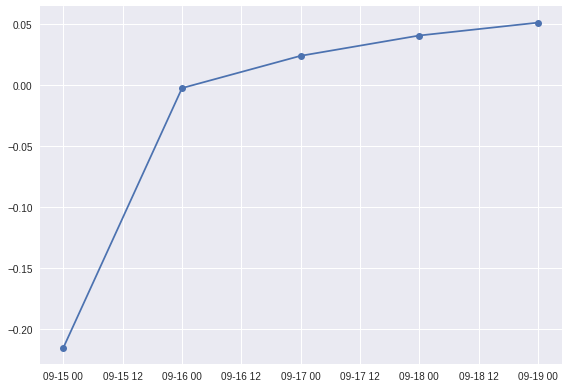

In [40]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['created_at']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

## 不同用戶端情緒時間趨勢

In [42]:
# 篩出安卓和蘋果的用戶
sentiment_source = sentiment_date[sentiment_date['source'].isin(['Twitter for Android', 'Twitter for iPad'])]
# 算每天的情緒
source_count = sentiment_source.groupby(['created_at','source'])['sentimentValue'].mean().reset_index()
source_count

,created_at,source,sentimentValue
0,2021-09-15,Twitter for Android,-0.276316
1,2021-09-15,Twitter for iPad,-0.090909
2,2021-09-16,Twitter for Android,0.127090
3,2021-09-16,Twitter for iPad,-0.195122
4,2021-09-17,Twitter for Android,0.037313
5,2021-09-17,Twitter for iPad,0.111111
6,2021-09-18,Twitter for Android,0.086643
7,2021-09-18,Twitter for iPad,0.068966
8,2021-09-19,Twitter for Android,0.107692
9,2021-09-19,Twitter for iPad,0.074074


In [43]:
# spread the column
source_pivot = source_count.pivot_table(index=['created_at'],columns='source',values='sentimentValue',fill_value=0).reset_index()
source_pivot

source,created_at,Twitter for Android,Twitter for iPad
0,2021-09-15,-0.276316,-0.090909
1,2021-09-16,0.127090,-0.195122
2,2021-09-17,0.037313,0.111111
3,2021-09-18,0.086643,0.068966
4,2021-09-19,0.107692,0.074074


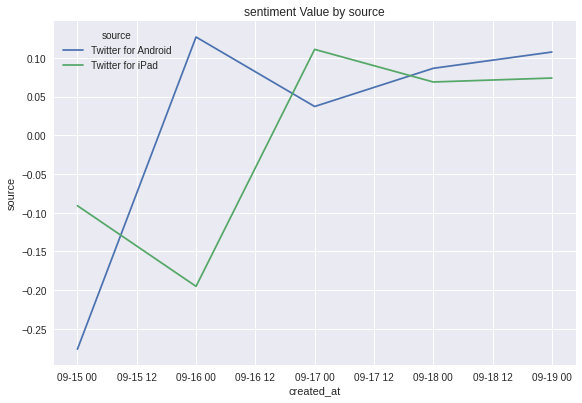

In [44]:
# 不同裝置情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="created_at", y=["Twitter for Android", "Twitter for iPad"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('source')
plt.title('sentiment Value by source')

plt.show()

### 正面詞彙探索
把正面文章挑出來，看看他們都用甚麼詞

In [45]:
# 挑出正面詞彙
positive = sentiment[sentiment['sentiment'].isin(['Positive', 'Verypositive'])] # 881
positive_words = pd.merge(positive,tokens,on='status_id',how='left')
positive_words.head(3)

,status_id,word_x,sentiment,word_y,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,RT,rt,NN,O,rt,rt
1,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,@anitakissee,@anitakissee,NN,HANDLE,@anitakissee,@anitakissee
2,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,:,:,:,O,:,:


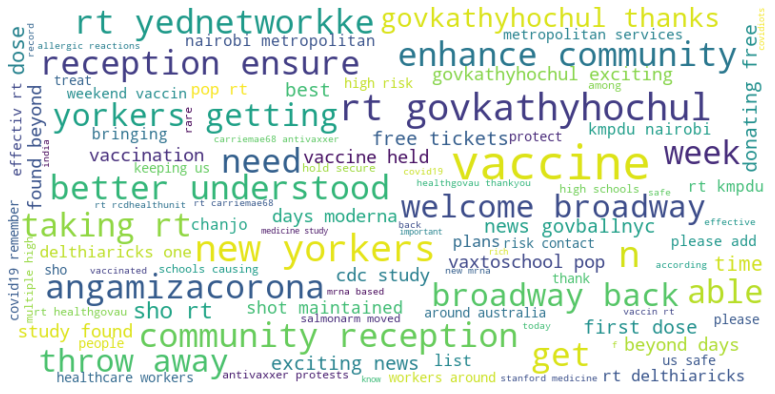

In [59]:


# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["co", "covid19vaccine","https","covid","tweeting"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=50, max_words=100,width=800, height = 400, background_color="white")\
                .generate(' '.join(positive_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

正面情緒部分來自於鼓勵接種的貼文，如紐約人「New Yorkers」接種疫苗「vaccine」可獲得$100美金，或者是解釋為甚麼接種疫苗，比直接染疫可以讓人產生更佳「better」的抗體。

In [49]:
# 挑出負面詞彙
negative = sentiment[sentiment['sentiment'].isin(['Negative', 'Verynegative'])] # 881
negative_words = pd.merge(negative,tokens,on='status_id',how='left')
negative_words.head(3)

,status_id,word_x,sentiment,word_y,lemma,pos,ner,word_lower,lemma_lower
0,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,If,if,IN,O,if,if
1,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,you,you,PRP,O,you,you
2,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,refuse,refuse,VBP,O,refuse,refuse


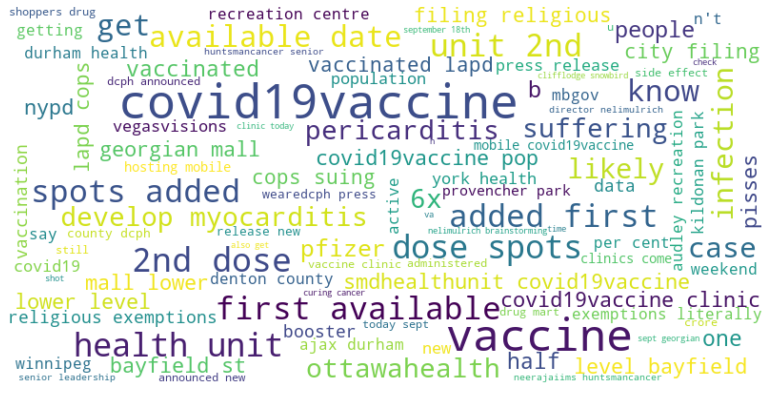

In [60]:


# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["co","rt", "https","covid"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=50, max_words=100,width=800, height = 400, background_color="white")\
                .generate(' '.join(negative_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面貼文部分和疫苗的處置相關，如有媒體認為經濟能力較差的國家不應該成為次級疫苗「COVID19Vaccine」試劑「doses」的傾倒場。或是警告比起負擔「suffering」疫苗的副作用，直接染疫的風險更大。如罹患心肌炎「myocarditis」的地風險會增加。

## TextBlob
+ 除了coreNLP 還有一些比較簡單的套件可以處理文字，在這裡介紹textBlob
+ 情緒計算
    + polarity > 0 是正面的字，反之是負面的
    + subjectivity 代表有多主觀
+ 第一步我們先把正負面的貼文挑出來，然後再看看通常正負面的貼文都用什麼樣的字

In [52]:
# 獲得一個句子的正負面情緒
from textblob import TextBlob ## pip install textblob
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
testimonial.sentiment

Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)

In [53]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

tweets_df['polarity'] = tweets_df['text'].apply(sentiment_calc)
tweets_df.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,polarity
0,2021-09-19 23:58:25,1439740696974409731,MPsLife,🐧 MP 🇺🇸,RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter for Android,0.392857
1,2021-09-19 23:55:24,1439739935959912448,AvgeekJoe,"joe a. kanzlar, VACCINATED & PLEASE BE VAXXED ...",RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter Web App,0.392857
2,2021-09-19 23:54:01,1439739587694268416,s_anand1,S.Anand,RT @StanfordMed: Allergic reactions to the new...,0,23,Twitter for iPhone,0.218182


In [54]:
# 挑出正負面情緒
positive = tweets_df.loc[tweets_df['polarity'] > 0][['status_id','polarity']]
negative = tweets_df.loc[tweets_df['polarity'] < 0][['status_id','polarity']]

In [55]:
# 去除停用字和標點符號


stop_words = set(stopwords.words('english'))
filter_tokens = tokens[~tokens.word.isin(list(stop_words))] # 82548 => 63024
filter_tokens = filter_tokens[filter_tokens.lemma_lower.str.isalpha()] # 63024 => 36778

In [56]:
filter_tokens

,status_id,word,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT,rt,NN,O,rt,rt
3,1439740696974409731,This,this,DT,O,this,this
6,1439740696974409731,favorite,favorite,JJ,O,favorite,favorite
8,1439740696974409731,video,video,NN,O,video,video
10,1439740696974409731,TikTok,TikTok,NNP,O,tiktok,tiktok
...,...,...,...,...,...,...,...
72163,1438181781564493824,September,September,NNP,DATE,september,september
72167,1438181781564493824,Canadian,canadian,JJ,NATIONALITY,canadian,canadian
72168,1438181781564493824,Mental,Mental,NNP,O,mental,mental
72169,1438181781564493824,Health,Health,NNP,O,health,health


In [62]:
positive_words = pd.merge(positive,filter_tokens[['status_id','lemma_lower']],on='status_id',how='left')
negative_words = pd.merge(negative,filter_tokens[['status_id','lemma_lower']],on='status_id',how='left')

看一下正面的句子都用甚麼樣的詞

In [63]:
positive_words.groupby(['lemma_lower'])['lemma_lower'] \
                         .count() \
                         .reset_index(name='count') \
                         .sort_values(['count'], ascending=False) \
                         .head(10)

,lemma_lower,count
1352,rt,1229
373,covid,718
966,medical,477
898,list,473
873,leaders,473
551,experts,472
605,following,471
185,black,470
818,interested,470
1623,trustworthy,469


In [64]:
# 看一下負面的都是甚麼字
negative_words.groupby(['lemma_lower'])['lemma_lower'] \
                         .count() \
                         .reset_index(name='count') \
                         .sort_values(['count'], ascending=False) \
                         .head(10)

,lemma_lower,count
673,rt,154
123,clinics,43
847,vaccine,42
796,today,40
592,pm,39
158,covid,35
785,this,32
563,park,31
335,health,30
579,people,27


### 補充：其他英文處理套件

#### emoji
+  emoji 轉英文字

In [66]:
# emoji to text
import emoji ## pip install emoji
print(emoji.demojize('Python is 👍'))

Python is :thumbs_up:


#### vaderSentiment
+ 分析英文句子情緒

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # pip install vaderSentiment

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
At least it isn't a horrible book.------------------------------- {'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.431}
The book was only kind of good.---------------------------------- {'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.3832}
The plot was good, but the characters are uncompelling and the dialog is not great. {'neg': 0.327, 'neu': 0.579, 'pos': 0.094, 'compound': -0.7042}
Today SUX!------------------------------------------------------- {'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}
Today only kinda sux! But I'll get by, lol----------------------- {'neg': 0.127, 'neu': 0.556, 'pos': 0.317, 'compound': 0.5249}
Make sure you :) or :D today!------------------------------------ {'neg': 0.0, 'neu': 0.

#### sentimentpy
+ github: https://github.com/trinker/sentimentpy
+ 請用這種方式安裝 `pip install git+https://github.com/trinker/sentimentpy`

In [69]:
# 把句子斷開，去除結尾空白符號
import sentimentpy.split_sentences as ss

s = [
    'I like carrots too mrs. dunbar. Well let\'s go to 100th st. around the corner.   ',
    'Hello Dr. Livingstone.  How are you?',
    'This is sill an incomplete thou.'
]

ss.split_sentences(s)

/usr/local/anaconda3/envs/test/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['I like carrots too mrs. dunbar.',
 "Well let's go to 100th st. around the corner.",
 'Hello Dr. Livingstone.',
 'How are you?',
 'This is sill an incomplete thou.']

### 相關參考連結
+ 相關文件
    + coreNLP
        + CoreNLPClient parameter
        + https://stanfordnlp.github.io/stanza/client_properties.html
    + tweetpy
        + API.search
        + https://docs.tweepy.org/en/v3.5.0/api.html#help-methods
        + API.search input output
        + https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets

+ 參考code
    + 抓取twitter table
    + https://amandeepsaluja.com/getting-twitter-keyword-data-in-table-format-using-python/